In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


In [2]:
data_path = "../data/raw/creditcard.csv"
df = pd.read_csv(data_path)

labels = df["Class"]
df = df.drop(columns=["Class"])


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df["Amount_scaled"] = scaler.fit_transform(df[["Amount"]])

df["transaction_count"] = 1
df["tx_per_min"] = df["transaction_count"].rolling(window=60).sum()

df["rolling_mean_amount"] = df["Amount"].rolling(window=60).mean()
df["rolling_std_amount"] = df["Amount"].rolling(window=60).std()

df["hour"] = (df["Time"] // 3600) % 24

df = df.fillna(0)


In [4]:
X = df.values


In [5]:
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42
)

iso_forest.fit(X)


,n_estimators,100
,max_samples,'auto'
,contamination,0.01
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


- n_estimators: number of trees

- contamination: expected anomaly rate (business assumption!)

- random_state: reproducibility

In [6]:
iso_scores = iso_forest.decision_function(X)


- Higher score → more normal

- Lower score → more anomalous

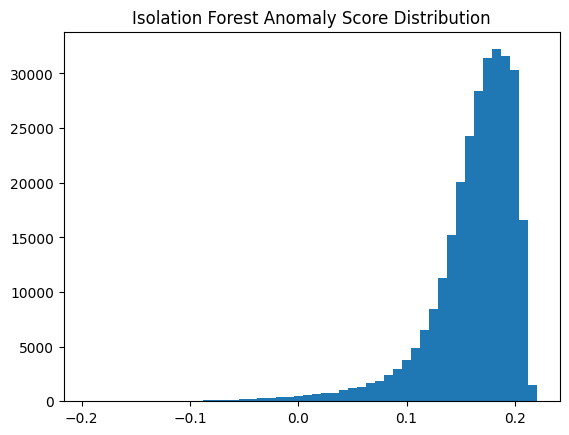

In [7]:
plt.hist(iso_scores, bins=50)
plt.title("Isolation Forest Anomaly Score Distribution")
plt.show()


- a dense cluster (normal)

- a long tail (anomalies)

In [8]:
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.01,
    novelty=True
)

lof.fit(X)


,n_neighbors,20
,algorithm,'auto'
,leaf_size,30
,metric,'minkowski'
,p,2
,metric_params,None
,contamination,0.01
,novelty,True
,n_jobs,None


In [9]:
lof_scores = lof.decision_function(X)


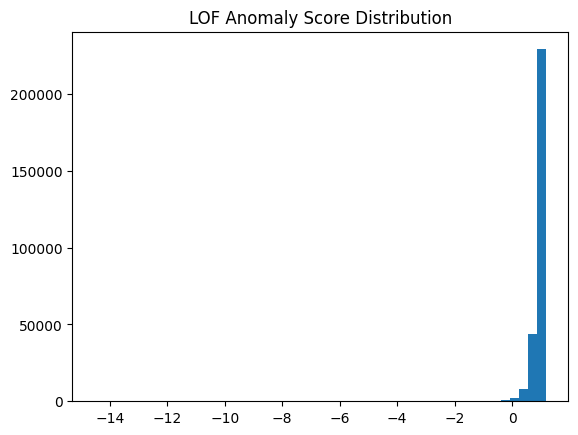

In [10]:
plt.hist(lof_scores, bins=50)
plt.title("LOF Anomaly Score Distribution")
plt.show()


**I compared Isolation Forest and LOF and chose Isolation Forest due to better score stability and production suitability.**


In [12]:
import sys
import os

sys.path.append(os.path.abspath(".."))


In [13]:
import pandas as pd
import joblib
from pathlib import Path

from sklearn.ensemble import IsolationForest

from src.features import build_features

In [14]:
DATA_PATH = "../data/raw/creditcard.csv"
MODEL_DIR = "../models"

Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)


In [15]:
df = pd.read_csv(DATA_PATH)

print("Data shape:", df.shape)


Data shape: (284807, 31)


In [22]:
df_features = df.drop(columns=["Class"])  # only input features
labels = df["Class"]

In [23]:
X, scaler, feature_df = build_features(df_features)

print("Corrected feature matrix shape:", X.shape)

Corrected feature matrix shape: (284807, 36)


In [24]:
iso_forest = IsolationForest(
    n_estimators=200,
    max_samples="auto",
    contamination=0.01,
    random_state=42,
    n_jobs=-1
)

In [25]:
iso_forest.fit(X)

print("Model training completed.")


Model training completed.


In [26]:
model_path = f"{MODEL_DIR}/isolation_forest.pkl"
scaler_path = f"{MODEL_DIR}/scaler.pkl"

joblib.dump(iso_forest, model_path)
joblib.dump(scaler, scaler_path)

print("Model saved to:", model_path)
print("Scaler saved to:", scaler_path)

Model saved to: ../models/isolation_forest.pkl
Scaler saved to: ../models/scaler.pkl


In [27]:
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)

test_scores = loaded_model.decision_function(X[:5])

print("Sanity check scores:", test_scores)

Sanity check scores: [0.16248153 0.1773091  0.06747855 0.14781939 0.15433859]
